# 1. Data Preparation and Feature Extraction

## 1.0 Import necessary libraries

In [34]:
## PANDAS
import pandas as pd

## NUMPY
import numpy as np

## SEABORN
import seaborn as sns

## SCIPY
from scipy.fftpack import fft
from scipy.signal import welch

## MATPLOTLIB
import matplotlib.pyplot as plt

## SKLEARN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

## TENSOR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

## SCIKERAS
from scikeras.wrappers import KerasRegressor



## 1.1 Load and Preprocess the Dataset

In [35]:
df = pd.read_csv("dataset/normalized_data.csv")
df

,eeg_1,eeg_2,eeg_3,eeg_4,eeg_5,eeg_6,eeg_7,eeg_8,eeg_9,eeg_10,...,eeg_243,eeg_244,eeg_245,eeg_246,eeg_247,eeg_248,eeg_249,eeg_250,score,normalized_form
0,0.7177,-0.2062,0.0475,1.0721,2.4135,3.5125,3.7577,2.7633,0.7151,-1.5270,...,9.8659,6.0245,-0.3442,-6.7022,-10.5920,-10.7050,-7.2834,-1.8025,9,0.905440
1,-20.2720,-15.5270,-7.3470,1.1873,7.7569,11.8050,14.1470,15.7500,16.7530,16.4740,...,-14.8110,-11.2060,-4.8725,1.8731,6.2072,6.1948,1.8273,-4.8429,7,0.723446
2,-2.5855,-3.6533,-3.1125,-1.5704,-0.2837,-0.3124,-1.8101,-3.9264,-5.3829,-5.3230,...,-0.1838,-3.6101,-8.3515,-12.8430,-15.1760,-14.1210,-9.8510,-3.9632,8,0.809585
3,3.1062,3.9020,4.1897,4.0014,3.4469,2.5849,1.4279,0.0445,-1.3564,-2.4403,...,14.7390,16.0430,16.1770,15.4330,14.1300,12.4790,10.6100,8.6729,8,0.813472
4,4.8654,4.2604,3.1231,1.7460,0.6860,0.5555,1.7299,4.1115,7.0969,9.7958,...,0.2532,0.0332,-1.3112,-3.5680,-5.8331,-6.8665,-5.7612,-2.5252,9,0.898316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,3.9657,5.3286,5.9334,5.4893,4.1019,2.3230,0.9462,0.6367,1.5860,3.3815,...,0.1096,-2.8541,-5.3169,-6.8093,-7.1329,-6.4084,-5.0492,-3.6339,10,0.986399
569,-0.7658,0.6194,2.6931,4.2242,4.2618,2.7016,0.3394,-1.6152,-2.2325,-1.3196,...,-2.5776,-1.2234,0.1361,0.8815,0.7860,0.1151,-0.5665,-0.7658,10,0.988990
570,7.9655,11.3100,12.2670,10.9120,8.0865,4.9417,2.4252,0.9726,0.4893,0.5447,...,-5.3580,-4.1075,-2.6476,-1.2086,0.0964,1.2556,2.2963,3.1921,10,0.987047
571,-0.6448,1.3528,1.6686,0.5742,-0.8300,-1.3065,-0.2264,2.0804,4.5637,6.1062,...,-4.0059,-3.2825,-2.2467,-0.9428,0.3840,1.3054,1.3794,0.3913,9,0.901554


In [36]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["score","normalized_form"]), df["normalized_form"], test_size=0.2, random_state=42)

In [37]:
X_train.shape

(458, 250)

In [38]:
X_test.shape

(115, 250)

## 1.2 Extract Frequency Bands

In [39]:
# Function to compute band power
def bandpower(data, sf, band, window_sec=None, relative=False):
    band = np.asarray(band)
    low, high = band
    
    # Define window length
    nperseg = (window_sec * sf) if window_sec else (2 / low * sf)
    
    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)
    
    # Frequency resolution
    freq_res = freqs[1] - freqs[0]
    
    # Find the intersection of the band and the PSD
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    
    # Integral approximation of the spectrum using Simpson's rule.
    band_power = np.trapz(psd[idx_band], dx=freq_res)
    
    if relative:
        band_power /= np.trapz(psd, dx=freq_res)
    
    return band_power

# Sampling frequency (250 Hz)
sf = 250
bands = [(4, 8), (8, 12), (12, 20), (20, 30)]

# Apply bandpower function to each record
def extract_features(record, bands, sf):
    features = []
    for band in bands:
        band_power = bandpower(record, sf, band)
        features.append(band_power)
    return features

# Extract features for training and testing sets
X_train_features = np.array([extract_features(record, bands, sf) for record in X_train.values])
X_test_features = np.array([extract_features(record, bands, sf) for record in X_test.values])


# 2. Model Training

In [40]:
# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


## 2.1 Random Forest Regressor


In [41]:
# Train Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_features, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_test_features)
mse_rf_initial = mean_squared_error(y_test, y_pred_rf)
r2_rf_initial = r2_score(y_test, y_pred_rf)
mape_rf_initial = mean_absolute_percentage_error(y_test, y_pred_rf)

print(f"Random Forest - MSE: {mse_rf_initial}, R2: {r2_rf_initial}, MAPE: {mape_rf_initial}")


Random Forest - MSE: 0.020297025922128627, R2: 0.023992688678983187, MAPE: 0.24065662691901996


## 2.2 LSTM

In [42]:
# Reshape data for LSTM
X_train_lstm = X_train_features.reshape((X_train_features.shape[0], 1, X_train_features.shape[1]))
X_test_lstm = X_test_features.reshape((X_test_features.shape[0], 1, X_test_features.shape[1]))

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile model
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Train model
history = model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test), verbose=2)

# Predict and evaluate
y_pred_lstm = model.predict(X_test_lstm)
mse_lstm_initial = mean_squared_error(y_test, y_pred_lstm)
r2_lstm_initial = r2_score(y_test, y_pred_lstm)
mape_lstm_initial = mean_absolute_percentage_error(y_test, y_pred_rf)

print(f"LSTM - MSE: {mse_lstm_initial}, R2: {r2_lstm_initial}, MAPE: {mape_lstm_initial}")

Epoch 1/50


/Users/dolphinium/anaconda3/envs/scikeras_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 - 1s - 62ms/step - loss: 0.6595 - val_loss: 0.4019
Epoch 2/50
15/15 - 0s - 2ms/step - loss: 0.2476 - val_loss: 0.0935
Epoch 3/50
15/15 - 0s - 2ms/step - loss: 0.0826 - val_loss: 0.0751
Epoch 4/50
15/15 - 0s - 2ms/step - loss: 0.0627 - val_loss: 0.0465
Epoch 5/50
15/15 - 0s - 2ms/step - loss: 0.0461 - val_loss: 0.0391
Epoch 6/50
15/15 - 0s - 2ms/step - loss: 0.0397 - val_loss: 0.0348
Epoch 7/50
15/15 - 0s - 2ms/step - loss: 0.0314 - val_loss: 0.0320
Epoch 8/50
15/15 - 0s - 2ms/step - loss: 0.0322 - val_loss: 0.0291
Epoch 9/50
15/15 - 0s - 2ms/step - loss: 0.0269 - val_loss: 0.0275
Epoch 10/50
15/15 - 0s - 2ms/step - loss: 0.0267 - val_loss: 0.0266
Epoch 11/50
15/15 - 0s - 2ms/step - loss: 0.0259 - val_loss: 0.0251
Epoch 12/50
15/15 - 0s - 2ms/step - loss: 0.0231 - val_loss: 0.0247
Epoch 13/50
15/15 - 0s - 2ms/step - loss: 0.0218 - val_loss: 0.0224
Epoch 14/50
15/15 - 0s - 2ms/step - loss: 0.0209 - val_loss: 0.0215
Epoch 15/50
15/15 - 0s - 2ms/step - loss: 0.0225 - val_loss: 0.0214

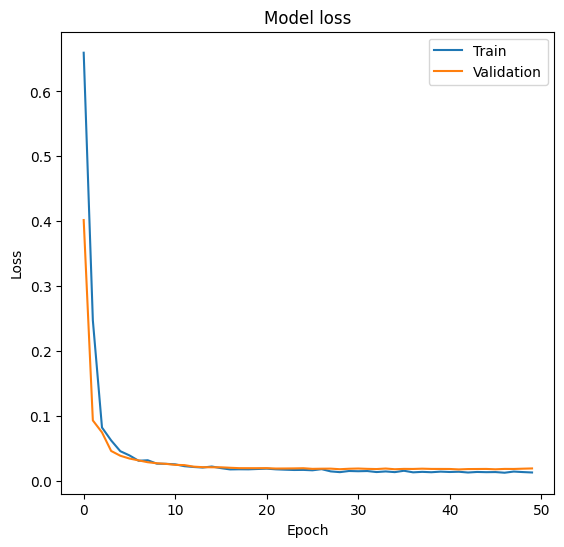

In [43]:
# Plot the loss
plt.figure(figsize=(14, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

## 2.3 Support Vector Regressor (SVR)

In [44]:
# Train SVR
svr = SVR(kernel='rbf')
svr.fit(X_train_features, y_train)

# Predict and evaluate
y_pred_svr = svr.predict(X_test_features)
mse_svr_initial = mean_squared_error(y_test, y_pred_svr)
r2_svr_initial = r2_score(y_test, y_pred_svr)
mape_svr_initial = mean_absolute_percentage_error(y_test, y_pred_rf)

print(f"SVR - MSE: {mse_svr_initial}, R2: {r2_svr_initial}, MAPE: {mape_svr_initial}")

SVR - MSE: 0.01980085111166146, R2: 0.047851861178797694, MAPE: 0.24065662691901996


# 3. Base Comparison and Analysis

In [45]:
results = {
    "Model": ["Random Forest", "LSTM", "SVR"],
    "MSE": [mse_rf_initial, mse_lstm_initial, mse_svr_initial],
    "R2": [r2_rf_initial, r2_lstm_initial, r2_svr_initial],
    "MAPE":[mape_rf_initial,mape_lstm_initial,mape_svr_initial]
}

results_df = pd.DataFrame(results)
results_df

,Model,MSE,R2,MAPE
0,Random Forest,0.020297,0.023993,0.240657
1,LSTM,0.019571,0.058923,0.240657
2,SVR,0.019801,0.047852,0.240657


# 4. Hyperparameter Tuning

## 4.1 Random Forest Regressor Tuning

In [46]:
# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train_features, y_train)

# Best parameters and performance
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_features)
mse_rf_tuned = mean_squared_error(y_test, y_pred_rf)
r2_rf_tuned = r2_score(y_test, y_pred_rf)
mape_rf_tuned = mean_absolute_percentage_error(y_test, y_pred_rf)

print(f"Best Random Forest - MSE: {mse_rf_tuned}, R2: {r2_rf_tuned}, MAPE: {mape_rf_tuned}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END m

## 4.2 LSTM Tuning

In [47]:
def build_lstm_model(units=50, dropout_rate=0.2, optimizer='adam'):
    model = Sequential()
    model.add(Input(shape=(1, 4)))  # Use Input layer to specify input shape
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Wrap the LSTM model with KerasRegressor
keras_regressor = KerasRegressor(model=build_lstm_model, verbose=0)

# Define parameter grid for RandomizedSearchCV
param_dist_lstm = {
    'model__units': [50, 100, 150],
    'model__dropout_rate': [0.2, 0.3, 0.4],
    'fit__batch_size': [32, 64, 128],
    'fit__epochs': [50, 100, 150],
    'model__optimizer': ['adam', 'rmsprop']
}

# Fit RandomizedSearchCV
random_search_lstm = RandomizedSearchCV(estimator=keras_regressor, param_distributions=param_dist_lstm, n_iter=20, cv=3, verbose=2, n_jobs=-1)

In [48]:
# Reshape data for LSTM
X_train_lstm = X_train_features.reshape((X_train_features.shape[0], 1, X_train_features.shape[1]))
X_test_lstm = X_test_features.reshape((X_test_features.shape[0], 1, X_test_features.shape[1]))

# Fit the RandomizedSearchCV with reshaped data
random_search_lstm.fit(X_train_lstm, y_train)

# Best parameters and performance for LSTM
best_lstm = random_search_lstm.best_estimator_
y_pred_lstm = best_lstm.predict(X_test_lstm)
mse_lstm_tuned = mean_squared_error(y_test, y_pred_lstm)
r2_lstm_tuned = r2_score(y_test, y_pred_lstm)
mape_lstm_tuned = mean_absolute_percentage_error(y_test, y_pred_lstm)

print(f"Best LSTM - MSE: {mse_lstm_tuned}, R2: {r2_lstm_tuned}, MAPE: {mape_lstm_tuned}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END fit__batch_size=128, fit__epochs=50, model__dropout_rate=0.3, model__optimizer=adam, model__units=100; total time=   3.8s
[CV] END fit__batch_size=128, fit__epochs=50, model__dropout_rate=0.3, model__optimizer=adam, model__units=100; total time=   3.9s
[CV] END fit__batch_size=128, fit__epochs=50, model__dropout_rate=0.3, model__optimizer=adam, model__units=100; total time=   3.8s


/Users/dolphinium/anaconda3/envs/scikeras_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END fit__batch_size=128, fit__epochs=100, model__dropout_rate=0.3, model__optimizer=rmsprop, model__units=50; total time=   4.7s
[CV] END fit__batch_size=128, fit__epochs=100, model__dropout_rate=0.3, model__optimizer=rmsprop, model__units=50; total time=   4.8s
[CV] END fit__batch_size=128, fit__epochs=100, model__dropout_rate=0.3, model__optimizer=rmsprop, model__units=50; total time=   4.8s
[CV] END fit__batch_size=128, fit__epochs=100, model__dropout_rate=0.2, model__optimizer=rmsprop, model__units=150; total time=   5.3s
[CV] END fit__batch_size=128, fit__epochs=100, model__dropout_rate=0.2, model__optimizer=rmsprop, model__units=150; total time=   5.4s
[CV] END fit__batch_size=64, fit__epochs=50, model__dropout_rate=0.2, model__optimizer=adam, model__units=100; total time=   4.6s
[CV] END fit__batch_size=64, fit__epochs=50, model__dropout_rate=0.2, model__optimizer=adam, model__units=100; total time=   4.3s
[CV] END fit__batch_size=64, fit__epochs=50, model__dropout_rate=0.2

[CV] END fit__batch_size=32, fit__epochs=150, model__dropout_rate=0.4, model__optimizer=rmsprop, model__units=50; total time=   8.1s
[CV] END fit__batch_size=32, fit__epochs=150, model__dropout_rate=0.4, model__optimizer=rmsprop, model__units=50; total time=   7.7s
[CV] END fit__batch_size=32, fit__epochs=150, model__dropout_rate=0.4, model__optimizer=rmsprop, model__units=50; total time=   8.2s


[CV] END fit__batch_size=128, fit__epochs=150, model__dropout_rate=0.2, model__optimizer=adam, model__units=100; total time=   7.3s


[CV] END fit__batch_size=64, fit__epochs=150, model__dropout_rate=0.3, model__optimizer=rmsprop, model__units=150; total time=   9.1s


[CV] END fit__batch_size=64, fit__epochs=150, model__dropout_rate=0.3, model__optimizer=rmsprop, model__units=150; total time=   9.0s


[CV] END fit__batch_size=64, fit__epochs=150, model__dropout_rate=0.3, model__optimizer=rmsprop, model__units=150; total time=   9.3s


[CV] END fit__batch_size=128, fit__epochs=150, model__dropout_rate=0.2, model__optimizer=adam, model__units=100; total time=   7.5s


[CV] END fit__batch_size=128, fit__epochs=150, model__dropout_rate=0.2, model__optimizer=adam, model__units=100; total time=   7.3s


[CV] END fit__batch_size=32, fit__epochs=100, model__dropout_rate=0.2, model__optimizer=adam, model__units=100; total time=   7.9s
[CV] END fit__batch_size=64, fit__epochs=100, model__dropout_rate=0.4, model__optimizer=adam, model__units=100; total time=   6.0s


[CV] END fit__batch_size=32, fit__epochs=100, model__dropout_rate=0.2, model__optimizer=adam, model__units=100; total time=   7.9s
[CV] END fit__batch_size=64, fit__epochs=100, model__dropout_rate=0.4, model__optimizer=adam, model__units=100; total time=   6.3s
[CV] END fit__batch_size=32, fit__epochs=100, model__dropout_rate=0.2, model__optimizer=adam, model__units=100; total time=   8.2s
[CV] END fit__batch_size=64, fit__epochs=100, model__dropout_rate=0.4, model__optimizer=adam, model__units=100; total time=   6.4s
[CV] END fit__batch_size=32, fit__epochs=50, model__dropout_rate=0.4, model__optimizer=rmsprop, model__units=50; total time=   4.6s
[CV] END fit__batch_size=32, fit__epochs=50, model__dropout_rate=0.4, model__optimizer=rmsprop, model__units=50; total time=   3.8s
[CV] END fit__batch_size=64, fit__epochs=50, model__dropout_rate=0.4, model__optimizer=adam, model__units=50; total time=   3.4s
[CV] END fit__batch_size=32, fit__epochs=50, model__dropout_rate=0.4, model__optimi

In [49]:
best_lstm

KerasRegressor(
	model=<function build_lstm_model at 0x31650a550>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	model__units=50
	model__optimizer=rmsprop
	model__dropout_rate=0.4
	fit__epochs=150
	fit__batch_size=32
)

## Rebuild best lstm

In [50]:
# Reshape data for LSTM
X_train_lstm = X_train_features.reshape((X_train_features.shape[0], 1, X_train_features.shape[1]))
X_test_lstm = X_test_features.reshape((X_test_features.shape[0], 1, X_test_features.shape[1]))

best_params = best_lstm.get_params()
best_units = best_params['model__units']
best_dropout_rate = best_params['model__dropout_rate']
best_optimizer = best_params['model__optimizer']
best_epochs = best_params['fit__epochs']
best_batch_size = best_params['fit__batch_size']


# Build LSTM model
model = Sequential()
model.add(LSTM(best_units, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dropout(best_dropout_rate))
model.add(LSTM(best_units))
model.add(Dropout(best_dropout_rate))
model.add(Dense(1))

# Compile model
model.compile(optimizer=best_optimizer, loss='mean_squared_error')

# Train model
best_history = model.fit(X_train_lstm, y_train, epochs=best_epochs, batch_size=best_batch_size, validation_data=(X_test_lstm, y_test), verbose=2)

Epoch 1/150


/Users/dolphinium/anaconda3/envs/scikeras_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 - 1s - 54ms/step - loss: 0.3995 - val_loss: 0.1184
Epoch 2/150
15/15 - 0s - 2ms/step - loss: 0.1101 - val_loss: 0.0655
Epoch 3/150
15/15 - 0s - 2ms/step - loss: 0.0828 - val_loss: 0.0443
Epoch 4/150
15/15 - 0s - 2ms/step - loss: 0.0577 - val_loss: 0.0331
Epoch 5/150
15/15 - 0s - 2ms/step - loss: 0.0503 - val_loss: 0.0266
Epoch 6/150
15/15 - 0s - 2ms/step - loss: 0.0367 - val_loss: 0.0268
Epoch 7/150
15/15 - 0s - 2ms/step - loss: 0.0368 - val_loss: 0.0234
Epoch 8/150
15/15 - 0s - 2ms/step - loss: 0.0331 - val_loss: 0.0208
Epoch 9/150
15/15 - 0s - 2ms/step - loss: 0.0278 - val_loss: 0.0214
Epoch 10/150
15/15 - 0s - 2ms/step - loss: 0.0276 - val_loss: 0.0195
Epoch 11/150
15/15 - 0s - 2ms/step - loss: 0.0238 - val_loss: 0.0203
Epoch 12/150
15/15 - 0s - 2ms/step - loss: 0.0267 - val_loss: 0.0191
Epoch 13/150
15/15 - 0s - 2ms/step - loss: 0.0255 - val_loss: 0.0198
Epoch 14/150
15/15 - 0s - 2ms/step - loss: 0.0245 - val_loss: 0.0193
Epoch 15/150
15/15 - 0s - 2ms/step - loss: 0.0225 - va

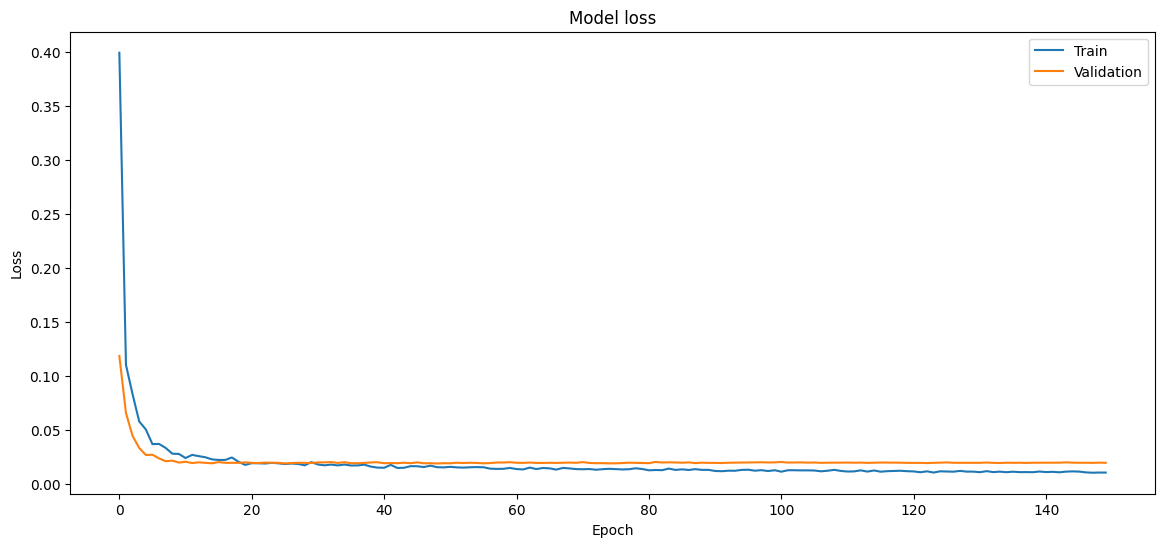

In [51]:
# Plot the loss
plt.figure(figsize=(14, 6))

# Plot training & validation loss values
plt.plot(best_history.history['loss'])
plt.plot(best_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

## 4.3 SVR Tuning

In [52]:
# Hyperparameter tuning for SVR
param_grid_svr = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.01, 0.1, 1]
}

grid_search_svr = GridSearchCV(estimator=SVR(kernel='rbf'), param_grid=param_grid_svr, cv=3, n_jobs=-1, verbose=2)
grid_search_svr.fit(X_train_features, y_train)

# Best parameters and performance
best_svr = grid_search_svr.best_estimator_
y_pred_svr = best_svr.predict(X_test_features)
mse_svr_tuned = mean_squared_error(y_test, y_pred_svr)
r2_svr_tuned = r2_score(y_test, y_pred_svr)
mape_svr_tuned = mean_absolute_percentage_error(y_test, y_pred_svr)

print(f"Best SVR - MSE: {mse_svr_tuned}, R2: {r2_svr_tuned}, MAPE: {mape_svr_tuned}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END ...................C=0.1, epsilon=0.01, gamma=scale; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.1, gamma=scale; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.01, gamma=auto; total time=   0.0s
[CV] END .....................C=0.1, epsilon=0.1, gamma=auto; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.01, gamma=auto; total time=   0.0s
[CV] END .....................C=0.1, epsilon=0.1, gamma=auto; total time=   0.0s
[CV] END .....................C=0.1, epsilon=0.1, gamma=auto; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.01, gamma=auto; total time=   0.0s
[CV] END ......................C=0.1, epsilon=1, gamma=scale; total time=   0.0s
[CV] END ......................C=0.1, epsilon=1, gamma=scale; total time=   0.0s
[CV] END ......................C=0.1, epsilon=1, gamma=scale; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.1,

## 4.4 Feature Importance Analysis from Random Forest

In [53]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = ['Band (4-8 Hz)', 'Band (8-12 Hz)', 'Band (12-20 Hz)', 'Band (20-30 Hz)']

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_features.shape[1]):
    print(f"{f + 1}. {features[indices[f]]} ({importances[indices[f]]})")


Feature ranking:
1. Band (12-20 Hz) (0.3592440910524334)
2. Band (20-30 Hz) (0.32340654047181994)
3. Band (4-8 Hz) (0.3173493684757467)
4. Band (8-12 Hz) (0.0)


# 5. Final Comparison

In [54]:
initial_results = {
    "Model": ["Random Forest (Initial)", "LSTM (Initial)", "SVR (Initial)"],
    "MSE": [mse_rf_initial, mse_lstm_initial, mse_svr_initial],
    "R2": [r2_rf_initial, r2_lstm_initial, r2_svr_initial],
    "MAPE": [mape_rf_initial, mape_lstm_initial, mape_svr_initial]
}

# Tuned model results
tuned_results = {
    "Model": ["Random Forest (Tuned)", "LSTM (Tuned)", "SVR (Tuned)"],
    "MSE": [mse_rf_tuned, mse_lstm_tuned, mse_svr_tuned],
    "R2": [r2_rf_tuned, r2_lstm_tuned, r2_svr_tuned],
    "MAPE": [mape_rf_tuned, mape_lstm_tuned, mape_svr_tuned]
}

# Combine results
combined_results = {
    "Model": initial_results["Model"] + tuned_results["Model"],
    "MSE": initial_results["MSE"] + tuned_results["MSE"],
    "R2": initial_results["R2"] + tuned_results["R2"],
    "MAPE": initial_results["MAPE"] + tuned_results["MAPE"]
}

# Create DataFrame
combined_results_df = pd.DataFrame(combined_results)

combined_results_df

,Model,MSE,R2,MAPE
0,Random Forest (Initial),0.020297,0.023993,0.240657
1,LSTM (Initial),0.019571,0.058923,0.240657
2,SVR (Initial),0.019801,0.047852,0.240657
3,Random Forest (Tuned),0.019065,0.083226,0.238599
4,LSTM (Tuned),0.019079,0.082555,0.236162
5,SVR (Tuned),0.019471,0.063735,0.237602


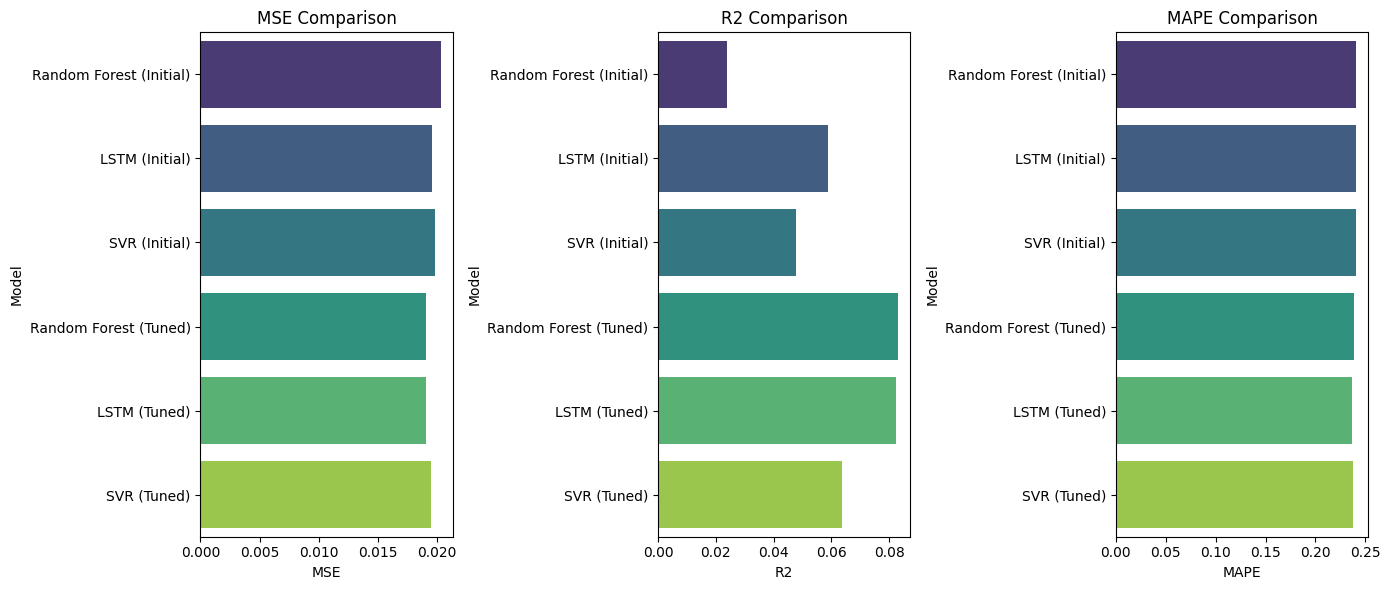

In [56]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Plot MSE
plt.subplot(1, 3, 1)
sns.barplot(x="MSE", y="Model", data=combined_results_df, hue="Model", palette="viridis", legend=False)
plt.title('MSE Comparison')

# Plot R2
plt.subplot(1, 3, 2)
sns.barplot(x="R2", y="Model", data=combined_results_df, hue="Model", palette="viridis", legend=False)
plt.title('R2 Comparison')

# Plot MAPE
plt.subplot(1, 3, 3)
sns.barplot(x="MAPE", y="Model", data=combined_results_df, hue="Model", palette="viridis", legend=False)
plt.title('MAPE Comparison')

# Show the plot
plt.tight_layout()
plt.show()


/var/folders/zp/vx4d93p11b14f5n2_d76gj040000gn/T/ipykernel_28916/3632056484.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0, 0], x="R2", y="Model", data=rf_results, palette="viridis")
/var/folders/zp/vx4d93p11b14f5n2_d76gj040000gn/T/ipykernel_28916/3632056484.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0, 1], x="R2", y="Model", data=lstm_results, palette="viridis")
/var/folders/zp/vx4d93p11b14f5n2_d76gj040000gn/T/ipykernel_28916/3632056484.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0, 2], x="R2

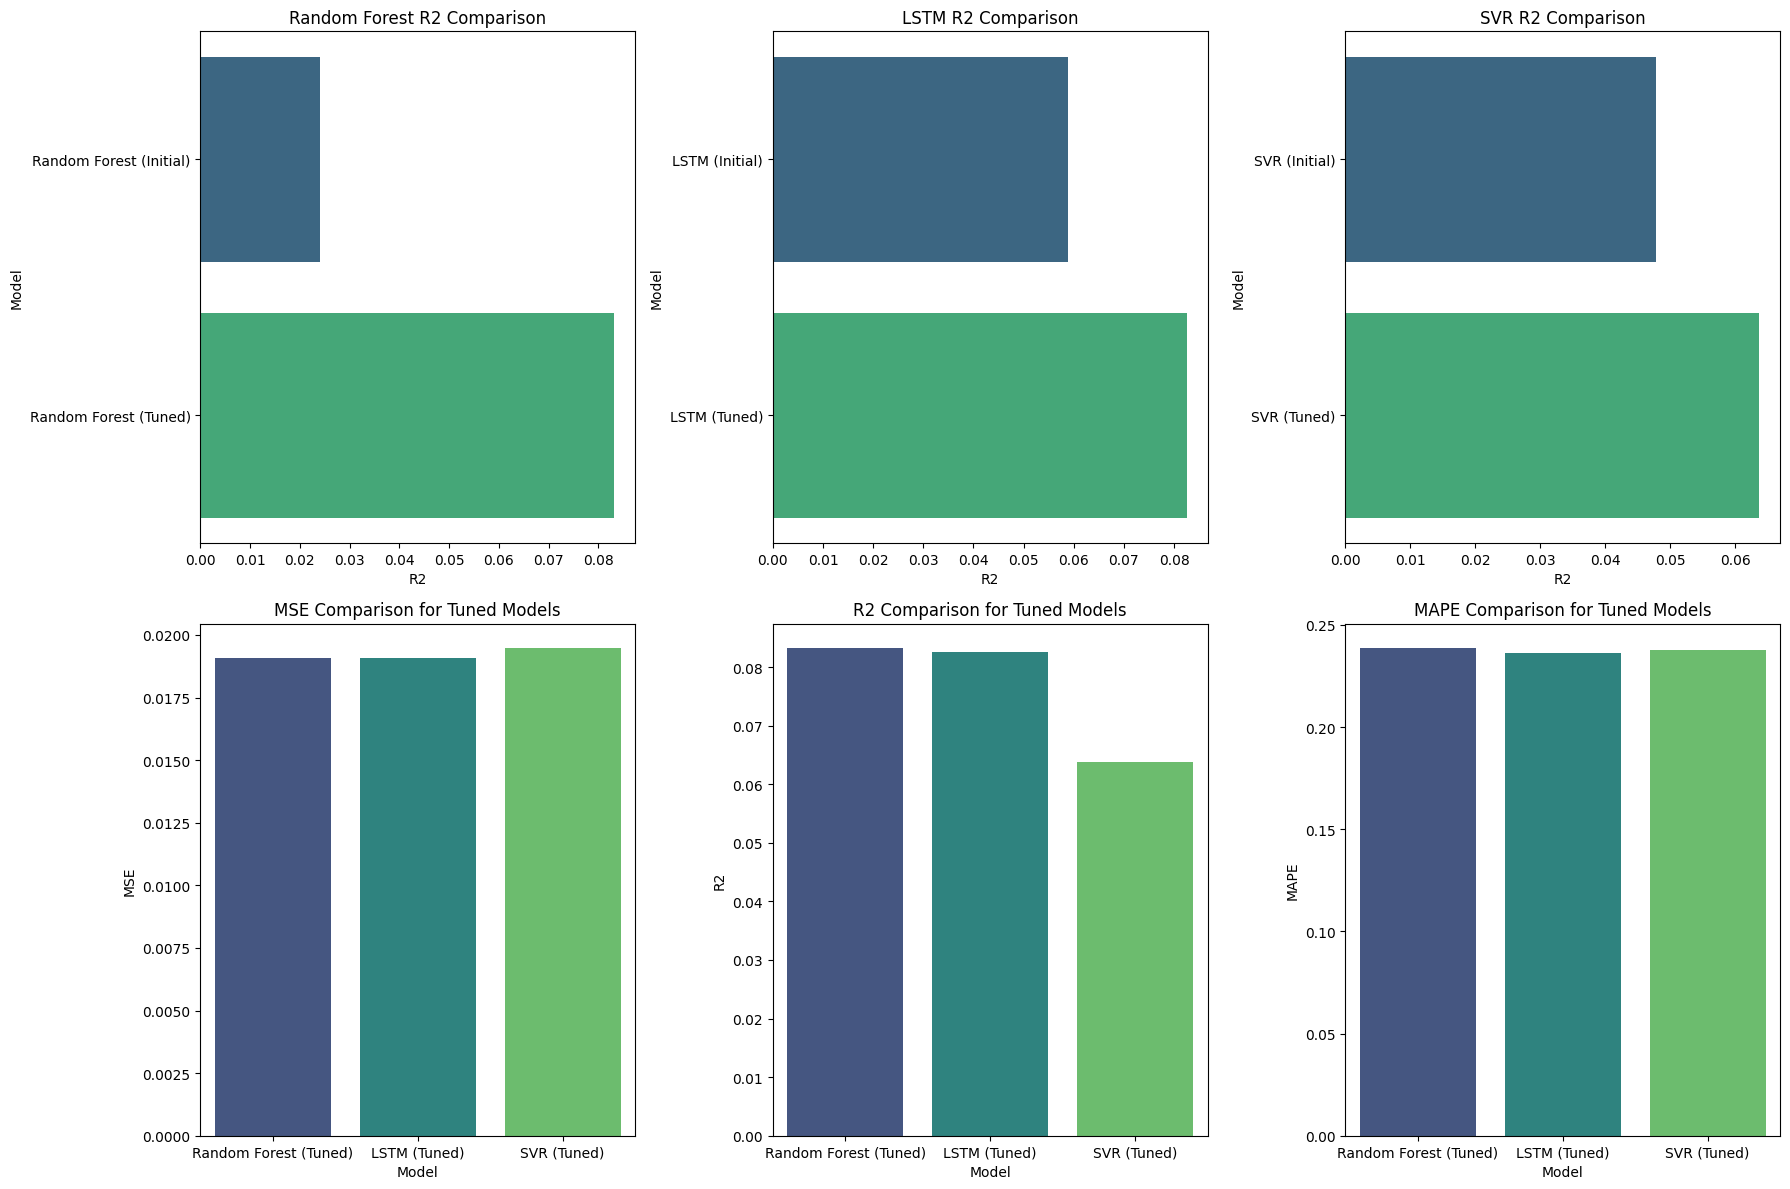

In [65]:
# Set up the matplotlib figure with two rows of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot Random Forest initial vs tuned R2 scores
sns.barplot(ax=axes[0, 0], x="R2", y="Model", data=rf_results, palette="viridis")
axes[0, 0].set_title('Random Forest R2 Comparison')

# Plot LSTM initial vs tuned R2 scores
sns.barplot(ax=axes[0, 1], x="R2", y="Model", data=lstm_results, palette="viridis")
axes[0, 1].set_title('LSTM R2 Comparison')

# Plot SVR initial vs tuned R2 scores
sns.barplot(ax=axes[0, 2], x="R2", y="Model", data=svr_results, palette="viridis")
axes[0, 2].set_title('SVR R2 Comparison')

# Plot MSE for tuned models
sns.barplot(ax=axes[1, 0], x="Model", y="MSE", data=tuned_results, palette="viridis")
axes[1, 0].set_title('MSE Comparison for Tuned Models')
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('MSE')

# Plot R2 for tuned models
sns.barplot(ax=axes[1, 1], x="Model", y="R2", data=tuned_results, palette="viridis")
axes[1, 1].set_title('R2 Comparison for Tuned Models')
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_ylabel('R2')

# Plot MAPE for tuned models
sns.barplot(ax=axes[1, 2], x="Model", y="MAPE", data=tuned_results, palette="viridis")
axes[1, 2].set_title('MAPE Comparison for Tuned Models')
axes[1, 2].set_xlabel('Model')
axes[1, 2].set_ylabel('MAPE')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
